In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import seaborn as sns
#import tensorflow.keras.backhand as K

from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.datasets import boston_housing

np.random.seed(0)

plt.rcParams['figure.figsize'] = (8.0, 5.0)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14

split the dataset into training & testing 

In [2]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


# Exploration
Let explore the data before building a model. The goal is to predict the median value of owner-occupied homes in $1000s.

In [3]:
# Create training/test dataframes for visualization/data exploration.
# Description of features: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT']
df_train = pd.DataFrame(x_train, columns=feature_names)
df_test = pd.DataFrame(x_test, columns=feature_names)

In [6]:
df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     404 non-null    float64
 1   ZN       404 non-null    float64
 2   INDUS    404 non-null    float64
 3   CHAS     404 non-null    float64
 4   NOX      404 non-null    float64
 5   RM       404 non-null    float64
 6   AGE      404 non-null    float64
 7   DIS      404 non-null    float64
 8   RAD      404 non-null    float64
 9   TAX      404 non-null    float64
 10  PTRATIO  404 non-null    float64
 11  B        404 non-null    float64
 12  LSTAT    404 non-null    float64
 13  price    404 non-null    float64
dtypes: float64(14)
memory usage: 44.3 KB


In [8]:
df_train.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
price      0
dtype: int64

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     102 non-null    float64
 1   ZN       102 non-null    float64
 2   INDUS    102 non-null    float64
 3   CHAS     102 non-null    float64
 4   NOX      102 non-null    float64
 5   RM       102 non-null    float64
 6   AGE      102 non-null    float64
 7   DIS      102 non-null    float64
 8   RAD      102 non-null    float64
 9   TAX      102 non-null    float64
 10  PTRATIO  102 non-null    float64
 11  B        102 non-null    float64
 12  LSTAT    102 non-null    float64
dtypes: float64(13)
memory usage: 10.5 KB


In [12]:
df_train['price'] = y_train
corr = df_train.corr()[['price']]
corr.style.background_gradient(cmap='coolwarm')

,price
CRIM,-0.378498
ZN,0.380299
INDUS,-0.476743
CHAS,0.168661
NOX,-0.438328
RM,0.681483
AGE,-0.364173
DIS,0.253900
RAD,-0.375515
TAX,-0.448737


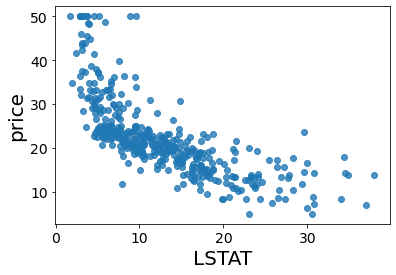

In [10]:
sns.regplot(x='LSTAT', y='price', data=df_train, fit_reg=False);

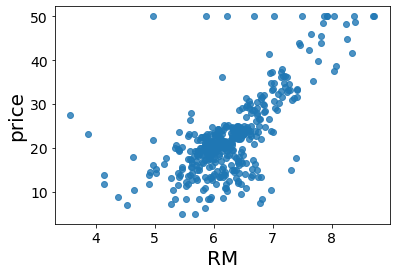

In [11]:
sns.regplot(x='RM', y='price', data=df_train, fit_reg=False);

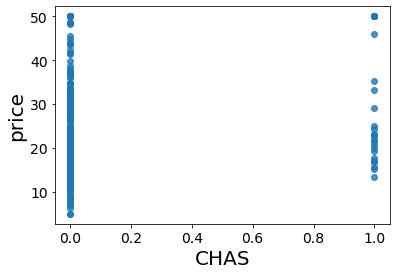

In [13]:
sns.regplot(x='CHAS', y='price', data=df_train, fit_reg=False);

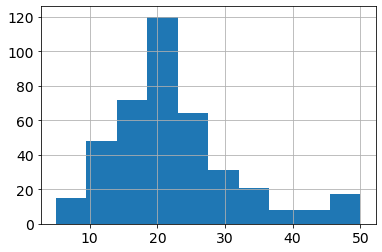

In [14]:
df_train.price.hist();

In [ ]:
df_train.price.hist();

## Train Gradient Boosting model

Training Steps to build model an ensemble of $K$ estimators.
1. At $k=0$ build base model ,  $\hat{y}_{0}$: $\hat{y}_{0}=base\_predicted$
3. Compute residuals $r = \sum_{i=0}^n (y_{k,i} - \hat{y}_{k,i})$; $n: number\ train\ examples$
4. Train new model, fitting on residuals, $r$. We will call the predictions from this model $e_{k}\_predicted$
5. Update model predictions at step $k$ by adding residual to current predictions: $\hat{y}_{k} = \hat{y}_{k-1} + e_{k}\_predicted$
6. Repeat steps 2 - 5 `K` times.

In summary, the goal is to build K estimators that learn to predict the residuals from the prior model; thus we are learning to "correct" the
predictions up until this point.
<br>

$\hat{y}_{K} = base\_predicted\ +\ \sum_{j=1}^Ke_{j}\_predicted$

In [61]:
class BaseModel(object):
    """Initial model that predicts mean of train set."""

    def __init__(self, y):
        self.train_mean = y.mean()

    def predict(self, x):
        """Return train mean for every prediction."""
        return np.ones(x.shape[0]) * self.train_mean

def pred(x, model):
    result = model.predict(x)
    return result.squeeze()  # Remove unnecessary dimension from prediction.

def compute_residuals(label, pred):
    """Compute difference of labels and predictions.

    When using mean squared error loss function, the residual indicates the 
    negative gradient of the loss function in prediction space. Thus by fitting
    the residuals, we performing gradient descent in prediction space. See for
    more detail:

    https://explained.ai/gradient-boosting/L2-loss.html
    """
    return label - pred

def compute_rmse(x):
    return np.sqrt(np.mean(np.square(x)))

In [62]:
# Build a base model that predicts the mean of the training set.
base_model = BaseModel(y_train)
test_pred = base_model.predict(x_test)
test_residuals = compute_residuals(y_test, test_pred)
print(compute_rmse(test_residuals))
print(len(test_residuals))

9.149363873885578
102


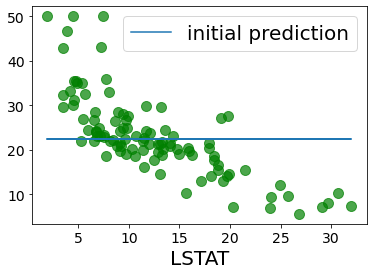

In [63]:
feature = df_test.LSTAT

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=10)
plt.plot(feature, test_pred, label='initial prediction')

plt.xlabel('LSTAT', size=20)
plt.legend(prop={'size': 20});

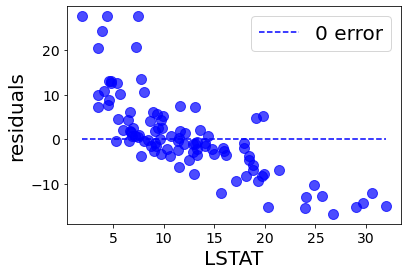

In [64]:
plt.plot(feature, test_residuals, 'bo', alpha=0.7, markersize=10)
plt.ylabel('residuals', size=20)
plt.xlabel('LSTAT', size=20)
plt.plot([feature.min(), feature.max()], [0, 0], 'b--', label='0 error');
plt.legend(prop={'size': 20});

In [65]:
def create_weak_model(**tree_params):
    """Initialize decision tree model."""
    model = DecisionTreeRegressor(**tree_params)
    return model

In [66]:
base_model = BaseModel(y_train)

In [103]:
# Training parameters. 
tree_params = {
    'max_depth': 2,
    'criterion': 'mse',
    'random_state': 123
  }
N_ESTIMATORS = 500
BOOSTING_LR = 0.005

# Initial prediction, residuals.
train_pred = base_model.predict(x_train)
test_pred = base_model.predict(x_test)
train_residuals = compute_residuals(y_train, train_pred)
test_residuals = compute_residuals(y_test, test_pred)

# Boosting.
train_rmse, test_rmse = [], []
for _ in range(0, N_ESTIMATORS):
    train_rmse.append(compute_rmse(train_residuals))
    test_rmse.append(compute_rmse(test_residuals))

    # Train weak learner.
    model = create_weak_model(**tree_params)
    model.fit(x_train, train_residuals)

    # Boosting magic happens here: add the residual prediction to correct
    # the prior model.
    grad_approx = model.predict(x_train)
    train_pred += (grad_approx * BOOSTING_LR)
    train_residuals = compute_residuals(y_train, train_pred)  
    
    # Keep track of residuals on validation set.
    grad_approx = model.predict(x_test)
    test_pred += grad_approx * BOOSTING_LR
    test_residuals = compute_residuals(y_test, test_pred)  

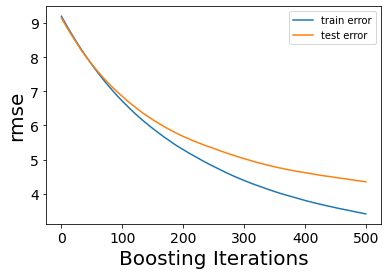

In [104]:
plt.figure()
plt.plot(train_rmse, label='train error')
plt.plot(test_rmse, label='test error')
plt.ylabel('rmse', size=20)
plt.xlabel('Boosting Iterations', size=20);
plt.legend()

In [105]:
df_train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'price'],
      dtype='object')

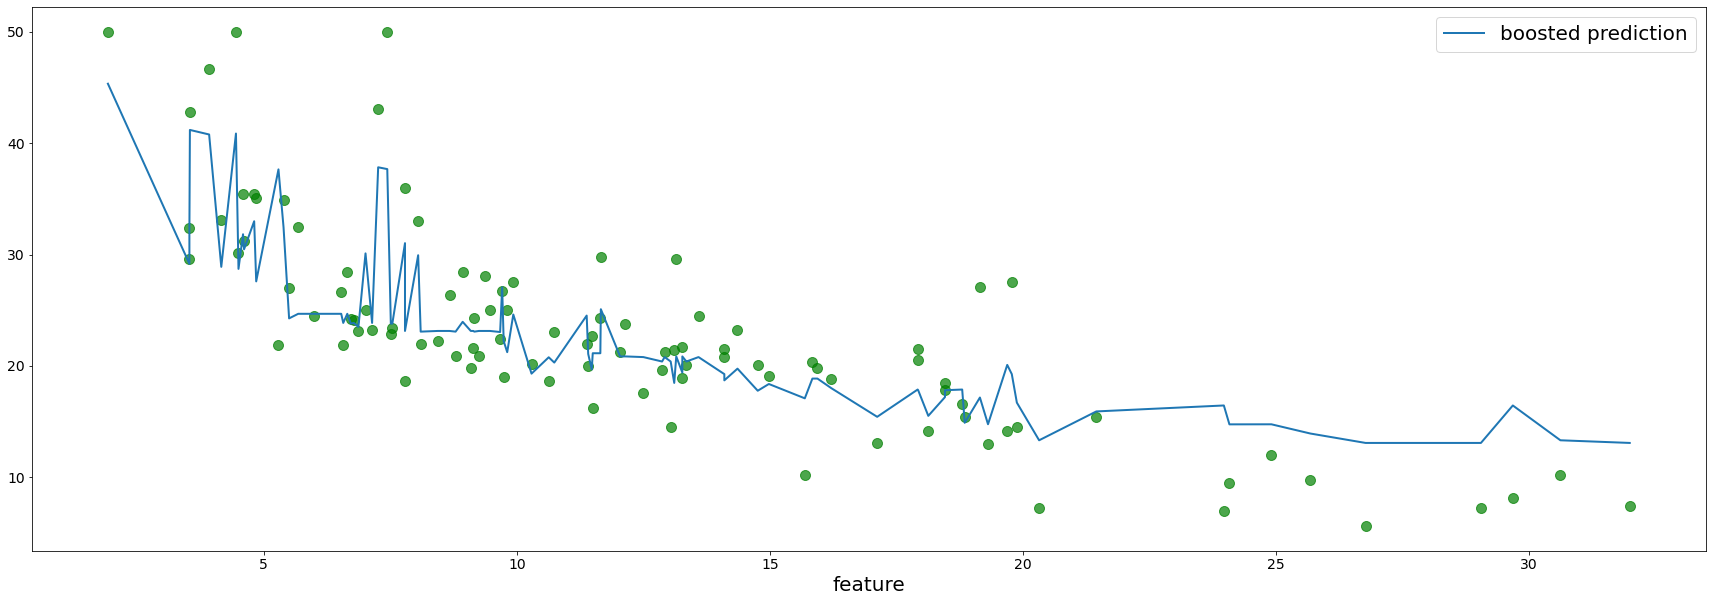

In [106]:
feature = df_test.LSTAT
ix = np.argsort(feature)
plt.figure(figsize=(30,10))

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=10)
plt.plot(feature[ix], test_pred[ix], label='boosted prediction', linewidth=2)

plt.xlabel('feature', size=20)
plt.legend(prop={'size': 20});

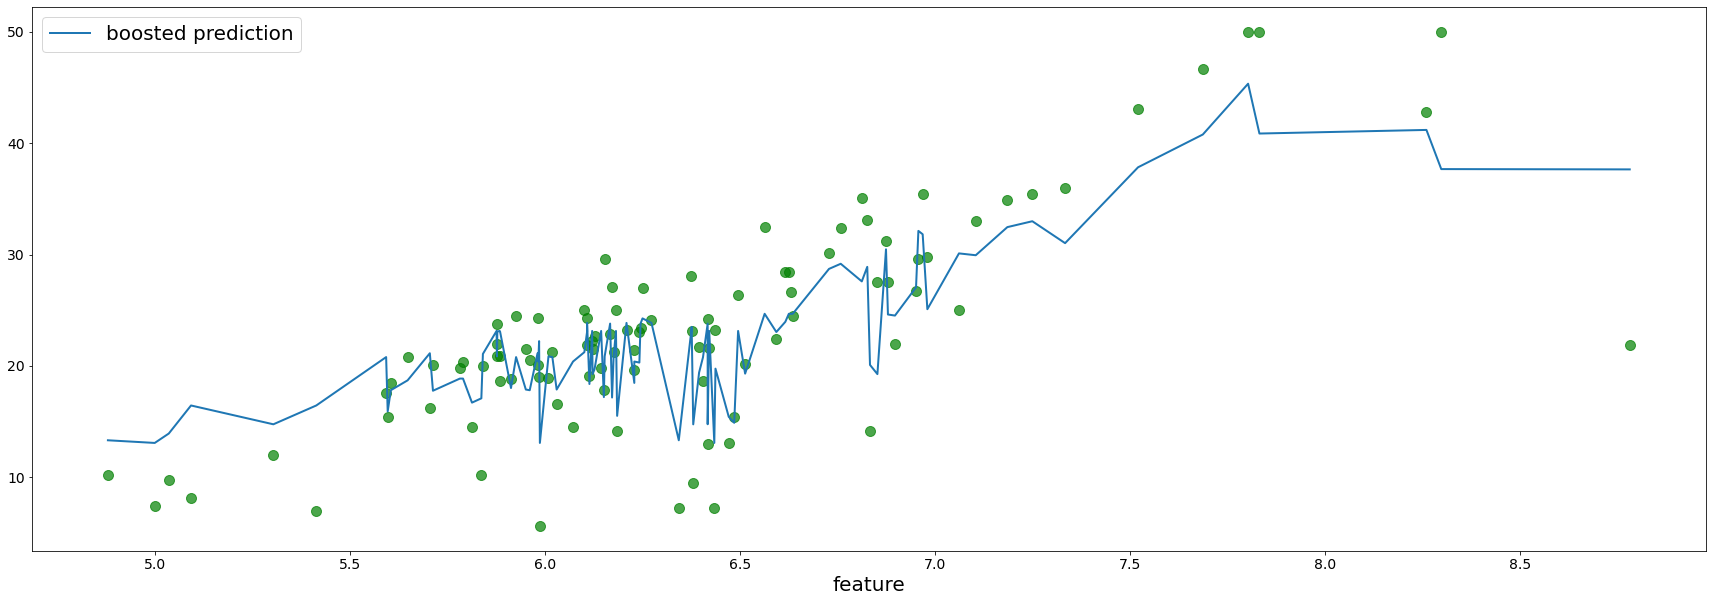

In [107]:
feature = df_test.RM
ix = np.argsort(feature)
plt.figure(figsize=(30,10))

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=10)
plt.plot(feature[ix], test_pred[ix], label='boosted prediction', linewidth=2)

plt.xlabel('feature', size=20)
plt.legend(prop={'size': 20});

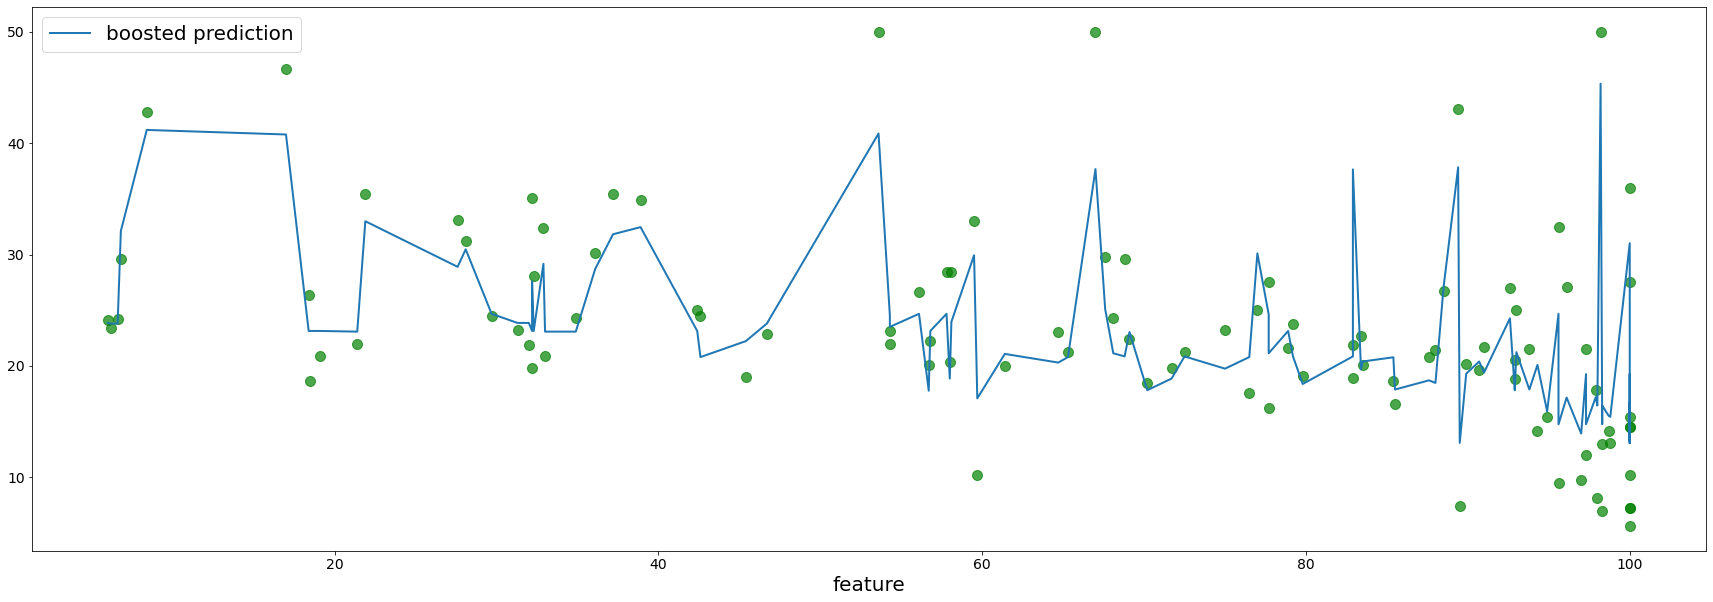

In [108]:
feature = df_test.AGE
ix = np.argsort(feature)
plt.figure(figsize=(30,10))

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=10)
plt.plot(feature[ix], test_pred[ix], label='boosted prediction', linewidth=2)

plt.xlabel('feature', size=20)
plt.legend(prop={'size': 20});

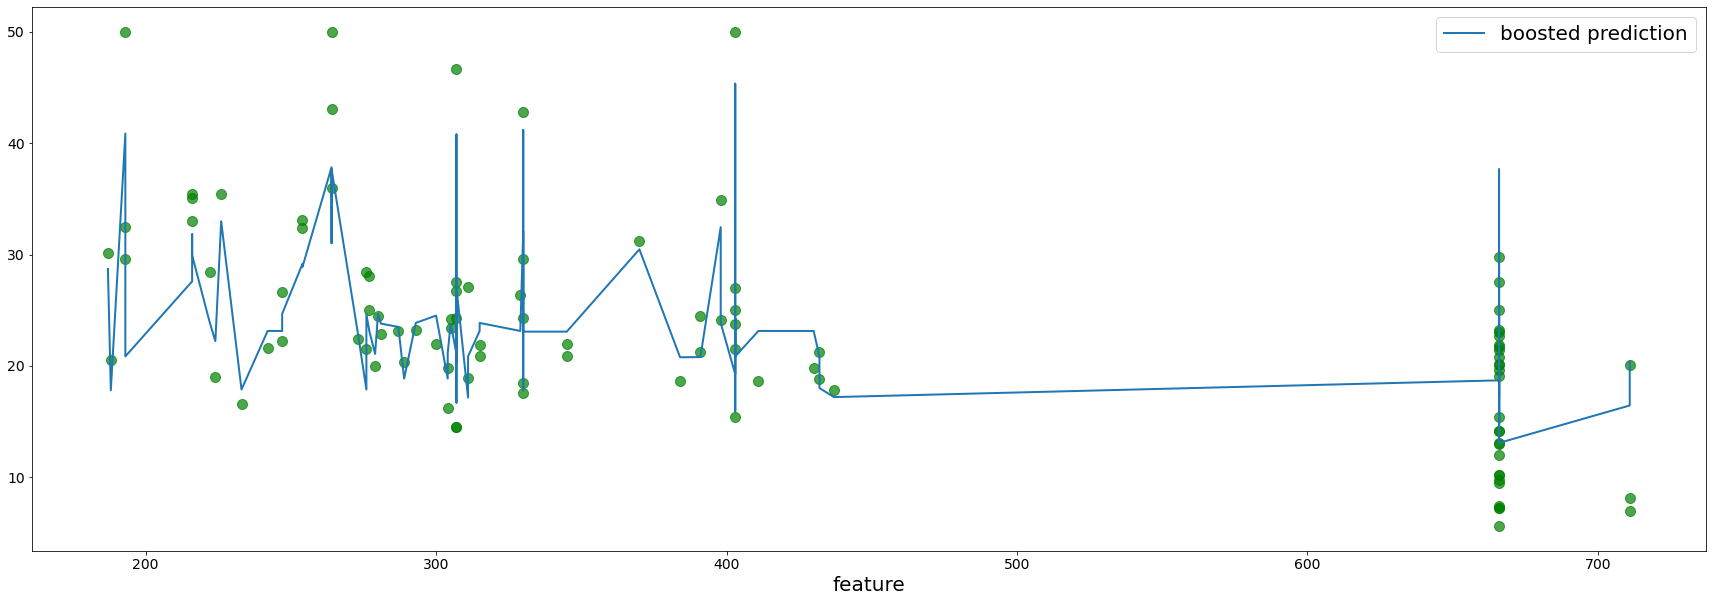

In [109]:
feature = df_test.TAX
ix = np.argsort(feature)
plt.figure(figsize=(30,10))

# Pick a predictive feature for plotting.
plt.plot(feature, y_test, 'go', alpha=0.7, markersize=10)
plt.plot(feature[ix], test_pred[ix], label='boosted prediction', linewidth=2)

plt.xlabel('feature', size=20)
plt.legend(prop={'size': 20});